In [20]:
import numpy as np
import tensorflow as tf
import tensorflow.python.platform
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline

# Global variables.
NUM_LABELS = 2    # The number of labels.
BATCH_SIZE = 100  # The number of training examples to use per training step.

In [21]:
# Helper function in place of original xrange() in python2
def xrange(x):
    return iter(range(x))

# Read the data from the given data file and extract the features and labels
def csv_data_reader(filename):
    # Arrays to hold the labels and features.
    label = []
    features = []
    with open(filename, 'r') as datafile:
        for line in datafile:
            row = line.split(",")
            label.append(int(row[2]))
            features.append([float(x) for x in row[0:2]])

    features_matrix = np.matrix(features).astype(np.float32)
    labels_vect = np.array(label).astype(dtype=np.uint8)
    labels_onehot = (np.arange(NUM_LABELS) == labels_vect[:, None]).astype(np.float32)
    #return the  features(1,2) and label
    return features_matrix,labels_onehot

# Init weights method. (Reference : Delip Rao: http://deliprao.com/archives/100)
def weight_initializer(shape, init_method='xavier', xavier_params = (None, None)):
    if init_method == 'zeros':
        return tf.Variable(tf.zeros(shape, dtype=tf.float32))
    elif init_method == 'uniform':
        return tf.Variable(tf.random_normal(shape, stddev=0.01, dtype=tf.float32))
    else: #xavier
        (fan_in, fan_out) = xavier_params
        low = -4*np.sqrt(6.0/(fan_in + fan_out)) # {sigmoid:4, tanh:1} 
        high = 4*np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))

def predictor(x,w_hidden,b_hidden,w_out,b_out):
    hidden = tf.nn.tanh(tf.matmul(tf.cast(x,tf.float32),w_hidden) + b_hidden)
    y = tf.nn.softmax(tf.matmul(tf.cast(hidden,tf.float32), w_out) + b_out)
    pred_result = tf.argmax(y,1)
    return pred_result.eval()

In [22]:
training_data_fname = "data/intro_to_ann3.csv"
test_data_fname = "data/intro_to_ann3.csv"

# Extract the csv data into numpy arrays.
train_data,train_labels = csv_data_reader(training_data_fname)
test_data, test_labels = csv_data_reader(test_data_fname)
train_size,num_features = train_data.shape
num_epochs =3000
num_hidden = 10

# The below place holders hold the features and label data
# that will be used by the program later
x = tf.placeholder("float", shape=[None, num_features])
y_ = tf.placeholder("float", shape=[None, NUM_LABELS])

test_data_node = tf.constant(test_data)

In [23]:
# Construct Phase
# Hidden weights and bias initialization
w_hidden = weight_initializer(
    [num_features, num_hidden],
    'uniform',
    xavier_params=(num_features, num_hidden))

b_hidden = weight_initializer([1,num_hidden],'zeros')
# Construct the hidden layers
hidden = tf.nn.tanh(tf.matmul(x,w_hidden) + b_hidden)
# output weights and bias initialization
w_out = weight_initializer(
    [num_hidden, NUM_LABELS],
    'uniform',
    xavier_params=(num_hidden, NUM_LABELS))
b_out = weight_initializer([1,NUM_LABELS],'zeros')
# Construct the output layer
y = tf.nn.softmax(tf.matmul(hidden, w_out) + b_out)
model = tf.initialize_all_variables()

In [24]:
# Optimization.
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.AdamOptimizer(0.1).minimize(cross_entropy)
# Verification Phase
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

At step:  0  System accuracy is: 0.5
At step:  100  System accuracy is: 0.962
At step:  200  System accuracy is: 0.968
At step:  300  System accuracy is: 0.97
At step:  400  System accuracy is: 0.97
At step:  500  System accuracy is: 0.97
At step:  600  System accuracy is: 0.97
At step:  700  System accuracy is: 0.97
At step:  800  System accuracy is: 0.968
At step:  900  System accuracy is: 0.968
At step:  1000  System accuracy is: 0.968
At step:  1100  System accuracy is: 0.968
At step:  1200  System accuracy is: 0.968
At step:  1300  System accuracy is: 0.968
At step:  1400  System accuracy is: 0.968
At step:  1500  System accuracy is: 0.968
At step:  1600  System accuracy is: 0.968
At step:  1700  System accuracy is: 0.968
At step:  1800  System accuracy is: 0.968
At step:  1900  System accuracy is: 0.97
At step:  2000  System accuracy is: 0.97
At step:  2100  System accuracy is: 0.97
At step:  2200  System accuracy is: 0.97
At step:  2300  System accuracy is: 0.97
At step:  2400  

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


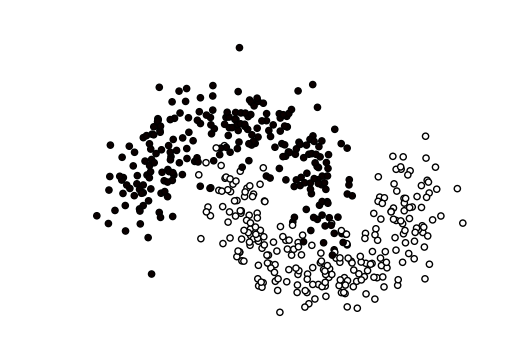

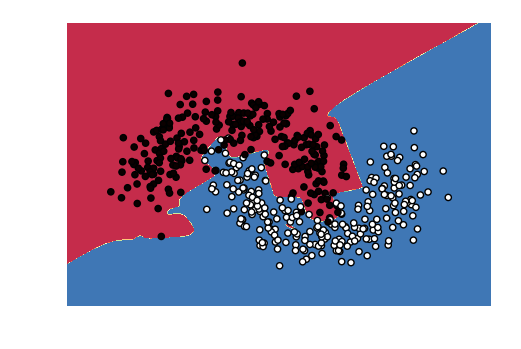

In [25]:
# Execution Phase.
with tf.Session() as sess:
    # Initialize all the variables.
    tf.initialize_all_variables().run()
    # Iterate and train.
    for step in xrange(num_epochs * train_size // BATCH_SIZE):
        offset = (step * BATCH_SIZE) % train_size
        batch_data = train_data[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        train_step.run(feed_dict={x: batch_data, y_: batch_labels})
        if step % 100 == 0:
            print ("At step: ", step, " System accuracy is:", accuracy.eval(feed_dict={x: test_data, y_: test_labels}))
    train = pd.read_csv("data/intro_to_ann3.csv")
    X, y = np.array(train.ix[:,0:2]), np.array(train.ix[:,2])

    cmhot = plt.cm.get_cmap("hot")
    plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=cmhot) 
    plt.axis('off')
    plt.show()

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = predictor(np.c_[xx.ravel(), yy.ravel()],w_hidden,b_hidden,w_out,b_out)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.axis('off')
    plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=cmhot)
    plt.show()
